In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from tqdm import tqdm 
import numpy as np

from committee_learning.initial_conditions import RandomNormalInitialConditions
from committee_learning.simulation import NormalizedSphericalConstraintSimulation

from committee_learning.sde.generalized_phase_retrieval import SphericalGeneralizedPhaseRetrievalSDE

n_ids = 10
save_per_decade = 5000
log_time = 1
noise = 1e-4
dt = 1e-3

k = 1
p = 1
d = 3000
gamma = .1
alpha = gamma / p
disable_QM_save=True
icid = 9

ic_string = 'randinint_{icid}'.format(icid=icid)

ics = RandomNormalInitialConditions(p, k, d, seed = icid, spherical=True)


In [30]:
from committee_learning.result import SimulationResult, PhaseRetrievalSDEResult, FullODEResult
from committee_learning.ode import SphericalSquaredActivationODE

from committee_learning.time_measure import exit_time

times = None
sim_risk = []
sde_risk = []

for id in tqdm(range(n_ids)):
    sim = NormalizedSphericalConstraintSimulation(
        d, p, k,
        Wt=ics.Wt,
        W0 = ics.W0,
        gamma=gamma,
        activation = 'square',
        noise=noise,
        disable_QM_save= disable_QM_save,
        seed=id^icid
        )
    sde = SphericalGeneralizedPhaseRetrievalSDE(
        Q0=ics.Q,
        M0=ics.M,
        d=d,
        dt=dt,
        gamma_over_p=gamma/p,
        noise_term=True,
        noise=noise,
        quadratic_terms=True,
        disable_QM_save= disable_QM_save,
        seed=id^icid
    )
    simr = SimulationResult(
        initial_condition='time-measure'+ic_string,
        id = id
    )
    sder = PhaseRetrievalSDEResult(
        initial_condition='time-measure'+ic_string,
        id = id
    )
    simr.from_file_or_run(
        sim,
        decades = log_time + np.log10((p*d)/gamma),
        path='computation-database/time-measure/sim/',
        show_progress=False,
        save_per_decade = save_per_decade
    )
    sder.from_file_or_run(
        sde,
        decades = log_time,
        path='computation-database/time-measure/sde/',
        show_progress=False,
        save_per_decade = save_per_decade
    )
    if id == 0:
        sim_times = simr.times
        sde_times = sder.times

    sim_risk.append(np.array(simr.risks))
    sde_risk.append(np.array(sder.risks))

sim_risk = np.array(sim_risk)
sde_risk = np.array(sde_risk)

ode = SphericalSquaredActivationODE(
    P0 = ics.P, Q0=ics.Q, M0=ics.M,
    dt=dt, noise_term=True, gamma_over_p=gamma/p, noise=noise,
    quadratic_terms=True, disable_QM_save= disable_QM_save
)
oder = FullODEResult(
    initial_condition='time-measure'+'ODE'+ic_string,
    id = 0
)
oder.from_file_or_run(
    ode,
    decades = log_time,
    path='computation-database/time-measure/ode/',
    show_progress=True
)

100%|██████████| 9000/9000 [00:00<00:00, 18382.62it/s]


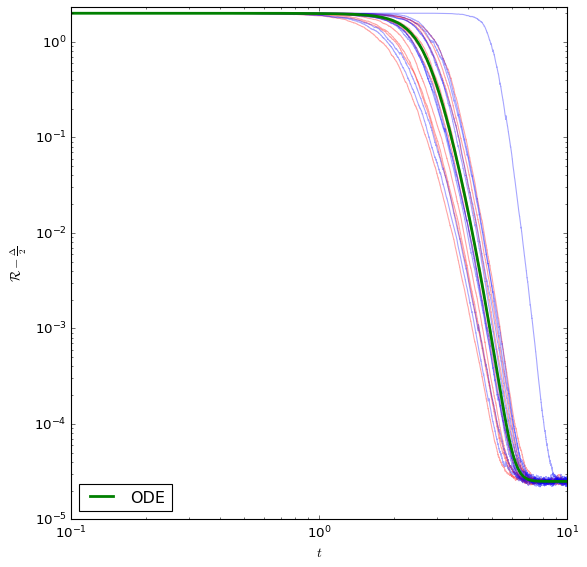

In [33]:
from committee_learning.utilities import plot_style
import matplotlib.pyplot as plt

with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  fig.patch.set_facecolor('white')
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(1e-1,1e1)
  ax.set_ylim(1e-5,2.3)
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$\mathcal{R}-\frac{\Delta}{2}$')


  ax.plot(
    sde_times,
    sde_risk.T,
    alpha = .35,
    c = 'red'
  )
  ax.plot(
    sim_times,
    sim_risk.T,
    alpha = .35,
    c = 'blue'
  )
  ax.plot(
    oder.times,
    oder.risks,
    label = f'ODE',
    lw=2.5,
    c = 'green'
  )
  
  ax.legend(loc='lower left')
  plt.show()